In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
# Defining file paths
hp_path = 'raw-datasets/hof_pitchers.xlsx'
nhp_path = 'raw-datasets/non-hof_pitchers.xlsx'
hh_path = 'raw-datasets/hof_hitters.xlsx'
nhh_path = 'raw-datasets/non-hof_hitters.xlsx'

# Creating a file for print statements to go into
file_path = 'hof_classification_notes.txt'
print_file = open(file_path, 'a')

# Reading files into dataframes
hof_pitchers = pd.read_excel(hp_path)
non_hof_pitchers = pd.read_excel(nhp_path)
hof_hitters = pd.read_excel(hh_path)
non_hof_hitters = pd.read_excel(nhh_path)

In [3]:
# Defining features for hitters
hitters_features = ['Player','From','To','G','PA','H','1B','2B','3B','HR','RBI','BA','OBP','SLG','OPS','OPS+','TB']

# Combining dataframes and adding "HoF" column
hof_hitters['HoF'] = 1
non_hof_hitters['HoF'] = 0
hitters_combined = pd.concat([hof_hitters,non_hof_hitters])

X_hitters = hitters_combined[hitters_features]
y_hitters = hitters_combined['HoF']

In [4]:
# Splitting data into those who played in the past 5 years and those who have last played prior to the past 5 years
hitters_pre_2020 = hitters_combined[hitters_combined['To'] < 2020]
hitters_since_2020 = hitters_combined[hitters_combined['To'] >= 2020]

# Splitting the pre-2020 hitters into train and test sets
X_hitters_pre_2020 = hitters_pre_2020[hitters_features]
y_hitters_pre_2020 = hitters_pre_2020['HoF']
X_train_hitters, X_test_hitters, y_train_hitters, y_test_hitters = train_test_split(X_hitters_pre_2020, y_hitters_pre_2020, test_size=0.2, random_state=69)

# Verifying
print(X_train_hitters.shape, X_test_hitters.shape)
print(y_train_hitters.shape, y_test_hitters.shape)

(5318, 17) (1330, 17)
(5318,) (1330,)


In [5]:
# Imputing missing values
imputer = SimpleImputer(strategy='mean')
imputer.fit(X_train_hitters.drop(columns=['Player']))
X_train_hitters_imputed = pd.DataFrame(imputer.transform(X_train_hitters.drop(columns=['Player'])), columns=X_train_hitters.columns.drop('Player'))
X_test_hitters_imputed = pd.DataFrame(imputer.transform(X_test_hitters.drop(columns=['Player'])), columns=X_test_hitters.columns.drop('Player'))
X_train_hitters_imputed['Player'] = X_train_hitters['Player'].values
X_test_hitters_imputed['Player'] = X_test_hitters['Player'].values

# Scaling the data
scaler = StandardScaler()
X_train_hitters_scaled = scaler.fit_transform(X_train_hitters_imputed.drop(columns=['Player']))
X_test_hitters_scaled = scaler.transform(X_test_hitters_imputed.drop(columns=['Player']))

Accuracy: 0.98
Precision: 0.95
Recall: 0.40
F1 Score: 0.57
Confusion Matrix:
[[1282   28]
 [   1   19]]


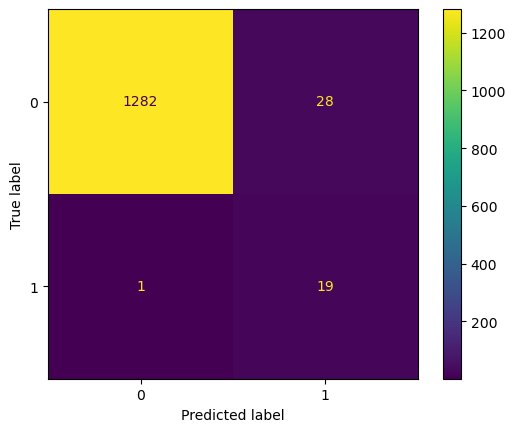

In [6]:
# Fitting SVM model on imputed data
svm_model_hitters = svm.SVC(kernel='rbf', gamma=0.012, C=1.0)
svm_model_hitters.fit(X_train_hitters_scaled, y_train_hitters)
y_predict_hitters = svm_model_hitters.predict(X_test_hitters_scaled)

# Calculating confusion matrix
accuracy = accuracy_score(y_test_hitters, y_predict_hitters)
precision = precision_score(y_test_hitters, y_predict_hitters, zero_division=0)
recall = recall_score(y_test_hitters, y_predict_hitters, zero_division=0)
f1 = f1_score(y_test_hitters, y_predict_hitters)

conf_matrix_hitters = confusion_matrix(y_predict_hitters, y_test_hitters)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f'Confusion Matrix:\n{conf_matrix_hitters}')

# Plotting the confusion matrix
cmd = ConfusionMatrixDisplay(conf_matrix_hitters)
fig, ax = plt.subplots(dpi = 100)
cmd.plot(ax=ax)
plt.savefig('confusion_matrix_hitters.png')

In [7]:
# Predicting on the test set
y_predict_hitters = svm_model_hitters.predict(X_test_hitters_scaled)

# Calculating components
tn, fp, fn, tp = confusion_matrix(y_test_hitters, y_predict_hitters).ravel()

fp_hitters = (y_test_hitters == 0) & (y_predict_hitters == 1)
fn_hitters = (y_test_hitters == 1) & (y_predict_hitters == 0)

# Retrieving false positives and false negatives
fp_hitters_indices = np.where(fp_hitters)[0]
fn_hitters_indices = np.where(fn_hitters)[0]

# Retrieving player names from the test set
fp_hitters_names = X_test_hitters.iloc[fp_hitters_indices]['Player'].values
fn_hitters_names = X_test_hitters.iloc[fn_hitters_indices]['Player'].values

# Printing the results
print(f"Hitters predicted to be HoF, but are actually Non-HoF: {fp_hitters_names}", file=print_file)
print(f"Hitters predicted to be Non-HoF, but are actually HoF: {fn_hitters_names}", file=print_file)

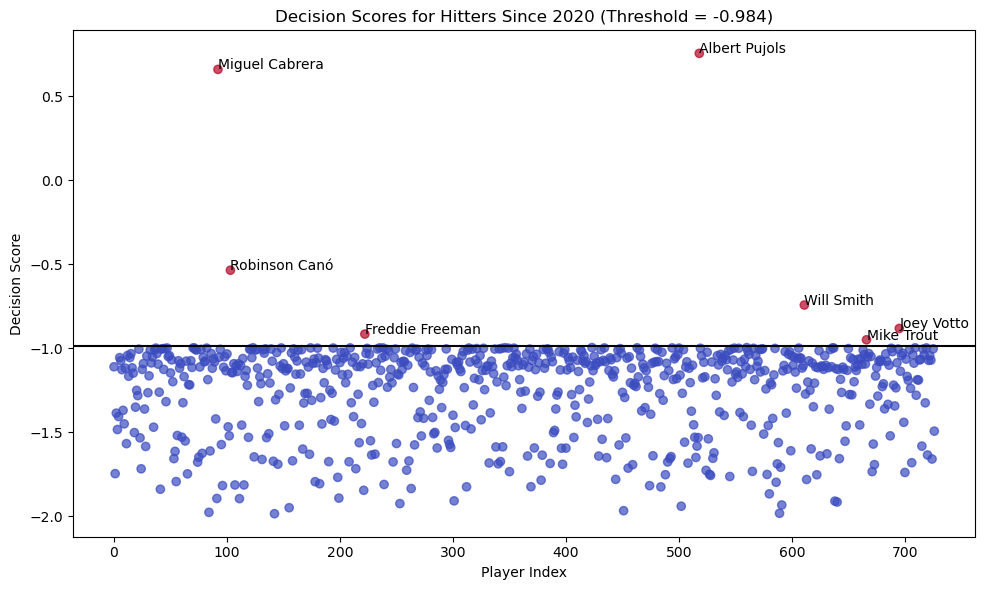

Miguel Cabrera
Robinson Canó
Freddie Freeman
Albert Pujols
Will Smith
Mike Trout
Joey Votto


In [8]:
# Imputing missing values for hitters_since_2020
X_hitters_since_2020 = hitters_since_2020[hitters_features].copy()
imputer.fit(X_hitters_since_2020.drop(columns=['Player']))
X_hitters_since_2020_imputed = pd.DataFrame(imputer.transform(X_hitters_since_2020.drop(columns=['Player'])), columns=X_hitters_since_2020.columns.drop('Player'))
X_hitters_since_2020_imputed['Player'] = X_hitters_since_2020['Player'].values

# Scaling the data
X_hitters_since_2020_scaled = scaler.transform(X_hitters_since_2020_imputed.drop(columns=['Player']))

# Computing decision scores
hitters_decision_scores = svm_model_hitters.decision_function(X_hitters_since_2020_scaled)

# Defining threshold
hitters_threshold = -0.984
hitters_predicted_labels = (hitters_decision_scores > hitters_threshold).astype(int)

# Plotting the figure
plt.figure(figsize=(10, 6))
plt.scatter(range(len(hitters_decision_scores)), hitters_decision_scores, c=hitters_predicted_labels, cmap='coolwarm', marker='o', alpha=0.7)
plt.title(f'Decision Scores for Hitters Since 2020 (Threshold = {hitters_threshold})')
plt.xlabel('Player Index')
plt.ylabel('Decision Score')

# Drawing a line at the threshold
plt.axhline(y=hitters_threshold, color='black', linestyle='-')

# Labeling points above the threshold with player names
hitters_above_threshold = X_hitters_since_2020[hitters_predicted_labels == 1]['Player'].values
for index, player in zip(np.where(hitters_predicted_labels == 1)[0], hitters_above_threshold):
    plt.text(index, hitters_decision_scores[index], player)

# Showing the plot
plt.tight_layout()
plt.savefig('hitters_hof_threshold.png')
plt.show()

# Printing the players above the threshold
hitters_above_threshold = X_hitters_since_2020[hitters_predicted_labels == 1]['Player'].values
print("Hitters predicted to be above the HoF threshold:", file=print_file)
for player in hitters_above_threshold:
    print_file.write(player + '\n')
    print(player)

In [9]:
# Defining features for pitchers
pitchers_features = ['Player','From','To','G','ERA','IP','ERA+','FIP','WHIP','H9','BB9','SO9','SO/BB']

# Combining dataframes and adding "HoF" column
hof_pitchers['HoF'] = 1
non_hof_pitchers['HoF'] = 0
pitchers_combined = pd.concat([hof_pitchers,non_hof_pitchers])

X_pitchers = pitchers_combined[pitchers_features]
y_pitchers = pitchers_combined['HoF']

In [10]:
# Splitting data into those who played in the past 5 years and those who have last played prior to the past 5 years
pitchers_pre_2020 = pitchers_combined[pitchers_combined['To'] < 2020]
pitchers_since_2020 = pitchers_combined[pitchers_combined['To'] >= 2020]

# Splitting the pre-2020 pitchers into train and test sets
X_pitchers_pre_2020 = pitchers_pre_2020[pitchers_features]
y_pitchers_pre_2020 = pitchers_pre_2020['HoF']
X_train_pitchers, X_test_pitchers, y_train_pitchers, y_test_pitchers = train_test_split(X_pitchers_pre_2020, y_pitchers_pre_2020, test_size=0.20, random_state=69)

# Verifying
print(X_train_pitchers.shape, X_test_pitchers.shape)
print(y_train_pitchers.shape, y_test_pitchers.shape)

(3977, 13) (995, 13)
(3977,) (995,)


In [11]:
# Imputing missing values
imputer = SimpleImputer(strategy='mean')
imputer.fit(X_train_pitchers.drop(columns=['Player']))
X_train_pitchers_imputed = pd.DataFrame(imputer.transform(X_train_pitchers.drop(columns=['Player'])), columns=X_train_pitchers.columns.drop('Player'))
X_test_pitchers_imputed = pd.DataFrame(imputer.transform(X_test_pitchers.drop(columns=['Player'])), columns=X_test_pitchers.columns.drop('Player'))
X_train_pitchers_imputed['Player'] = X_train_pitchers['Player'].values
X_test_pitchers_imputed['Player'] = X_test_pitchers['Player'].values

# Scaling the data
scaler = StandardScaler()
X_train_pitchers_scaled = scaler.fit_transform(X_train_pitchers_imputed.drop(columns=['Player']))
X_test_pitchers_scaled = scaler.transform(X_test_pitchers_imputed.drop(columns=['Player']))

Accuracy: 0.99
Precision: 0.89
Recall: 0.59
F1 Score: 0.71
Confusion Matrix:
[[964  12]
 [  2  17]]


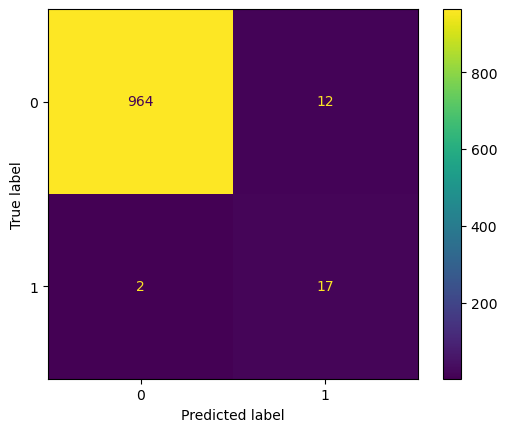

In [12]:
# Fitting SVM model on imputed data
svm_model_pitchers = svm.SVC(kernel='rbf', gamma=0.003, C=600)
svm_model_pitchers.fit(X_train_pitchers_scaled, y_train_pitchers)
y_predict_pitchers = svm_model_pitchers.predict(X_test_pitchers_scaled)

# Calculating confusion matrix
accuracy = accuracy_score(y_test_pitchers, y_predict_pitchers)
precision = precision_score(y_test_pitchers, y_predict_pitchers, zero_division=0)
recall = recall_score(y_test_pitchers, y_predict_pitchers, zero_division=0)
f1 = f1_score(y_test_pitchers, y_predict_pitchers)

conf_matrix_pitchers = confusion_matrix(y_predict_pitchers, y_test_pitchers)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f'Confusion Matrix:\n{conf_matrix_pitchers}')

# Plotting the confusion matrix
cmd = ConfusionMatrixDisplay(conf_matrix_pitchers)
fig, ax = plt.subplots(dpi = 100)
cmd.plot(ax=ax)
plt.savefig('confusion_matrix_pitchers.png')

In [13]:
# Predicting on the test set
y_predict_pitchers = svm_model_pitchers.predict(X_test_pitchers_scaled)

# Calculating components
tn, fp, fn, tp = confusion_matrix(y_test_pitchers, y_predict_pitchers).ravel()

fp_pitchers = (y_test_pitchers == 0) & (y_predict_pitchers == 1)
fn_pitchers = (y_test_pitchers == 1) & (y_predict_pitchers == 0)

# Retrieving false positives and false negatives
fp_pitchers_indices = np.where(fp_pitchers)[0]
fn_pitchers_indices = np.where(fn_pitchers)[0]

# Retrieving player names from the test set
fp_pitchers_names = X_test_pitchers.iloc[fp_pitchers_indices]['Player'].values
fn_pitchers_names = X_test_pitchers.iloc[fn_pitchers_indices]['Player'].values

# Printing the results
print(f"Pitchers predicted to be HoF, but are actually Non-HoF: {fp_pitchers_names}", file=print_file)
print(f"Pitchers predicted to be Non-HoF, but are actually HoF: {fn_pitchers_names}", file=print_file)

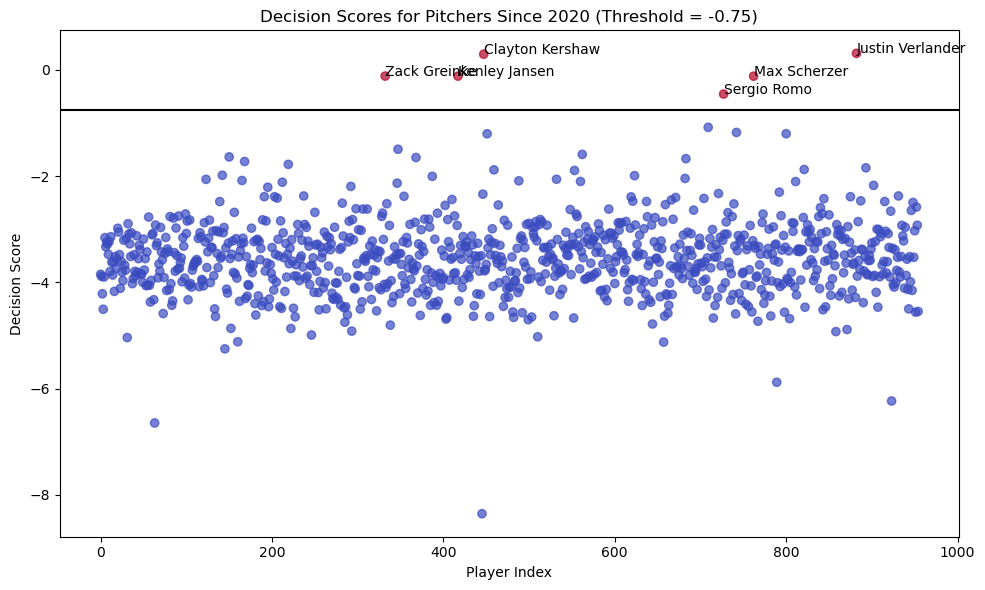

Zack Greinke
Kenley Jansen
Clayton Kershaw
Sergio Romo
Max Scherzer
Justin Verlander


In [14]:
# Imputing missing values for pitchers_since_2020
X_pitchers_since_2020 = pitchers_since_2020[pitchers_features].copy()
imputer.fit(X_pitchers_since_2020.drop(columns=['Player']))
X_pitchers_since_2020_imputed = pd.DataFrame(imputer.transform(X_pitchers_since_2020.drop(columns=['Player'])), columns=X_pitchers_since_2020.columns.drop('Player'))
X_pitchers_since_2020_imputed['Player'] = X_pitchers_since_2020['Player'].values

# Scaling the data
X_pitchers_since_2020_scaled = scaler.transform(X_pitchers_since_2020_imputed.drop(columns=['Player']))

# Computing decision scores
pitchers_decision_scores = svm_model_pitchers.decision_function(X_pitchers_since_2020_scaled)

# Defining threshold
pitchers_threshold = -0.75
pitchers_predicted_labels = (pitchers_decision_scores > pitchers_threshold).astype(int)

# Plotting the figure
plt.figure(figsize=(10, 6))
plt.scatter(range(len(pitchers_decision_scores)), pitchers_decision_scores, c=pitchers_predicted_labels, cmap='coolwarm', marker='o', alpha=0.7)
plt.title(f'Decision Scores for Pitchers Since 2020 (Threshold = {pitchers_threshold})')
plt.xlabel('Player Index')
plt.ylabel('Decision Score')

# Drawing a line at the threshold
plt.axhline(y=pitchers_threshold, color='black', linestyle='-')

# Labeling points above the threshold with player names
pitchers_above_threshold = X_pitchers_since_2020[pitchers_predicted_labels == 1]['Player'].values
for index, player in zip(np.where(pitchers_predicted_labels == 1)[0], pitchers_above_threshold):
    plt.text(index, pitchers_decision_scores[index], player)

# Showing the plot
plt.tight_layout()
plt.savefig('pitchers_hof_threshold.png')
plt.show()

# Printing the players above the threshold
pitchers_above_threshold = X_pitchers_since_2020[pitchers_predicted_labels == 1]['Player'].values
print("Pitchers predicted to be above the HoF threshold:", file=print_file)
for player in pitchers_above_threshold:
    print_file.write(player + '\n')
    print(player)

In [15]:
print_file.close

<function TextIOWrapper.close()>